# Finding Lane Lines on the Road
Author by NK Zhehua Zou

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2

# Function Set

In [2]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#  connect/average/extrapolate line segments 
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    imshape = img.shape
    left_lines = []
    right_lines = []
    global last_lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            x0 = x1 + ((imshape[0] - y1) / slope)
            if  slope < -0.5 and slope > -2:
                left_lines.append([x0,slope])
            elif slope > 0.5 and slope > -2:
                right_lines.append([x0,slope])
            else:
                pass
    try:
        left_lane_x0_list, left_lane_slope_list = zip(*left_lines)
        left_lane_x0 = int(np.mean(left_lane_x0_list))
        left_lane_slope = np.mean(left_lane_slope_list)
    except:
        left_lane_x0 = last_lanes[0]
        left_lane_slope = last_lanes[1]
        
    cv2.line(img, (left_lane_x0, imshape[0]), (left_lane_x0 - (int((imshape[0] - imshape[0]*3/5)/left_lane_slope)),
                                               int(imshape[0]*3/5)), color, thickness)
    try:    
        right_lane_x0_list, right_lane_slope_list = zip(*right_lines)
        right_lane_x0 = int(np.mean(right_lane_x0_list))
        right_lane_slope = np.mean(right_lane_slope_list)
    except:
        right_lane_x0 = last_lanes[2]
        right_lane_slope = last_lanes[3]
        
    cv2.line(img, (right_lane_x0, imshape[0]), (right_lane_x0 - (int((imshape[0] - imshape[0]*3/5)/right_lane_slope)),
                                                int(imshape[0]*3/5)), color, thickness)
    last_lanes = [left_lane_x0, left_lane_slope, right_lane_x0, right_lane_slope]
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Test on images

In [3]:
# Read images
import os  #cv2 only read one image, os can read a set of images from a folder
images = os.listdir("test_images/")
print(images)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


In [4]:
# pipeline
def process_images(img):
    image = mpimg.imread(img) # read image
    gray = grayscale(image) # grayscale conversion
    blur_gauss = gaussian_blur(gray, 3) # Define a kernel size for Gaussian smoothing/blurring, kernel=5
    edges = canny(blur_gauss, 50, 150) # low_threshold = 50, high_threshold = 150
    # created masked_edges by fillPoly()
    imshape = image.shape
    # need to very careful at apex parameter, it is easy to fail to connect line segments
    vertices = np.array([[(0, imshape[0]), ((image.shape[1]*1/2)-20, image.shape[0]*5/8),
                          ((image.shape[1]*1/2)+20, image.shape[0]*5/8), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # implement hough transform and draw lines onto original image
    # smaller threshold make extended lines color stronger and mess, larger max_line_gap can extrapolate line
    lines = hough_lines(masked_edges, 2, np.pi/180, 30, 100, 160)
    # add lines onto original image
    combo = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    #Display plot:
    plt.imshow(combo);

solidWhiteCurve.jpg


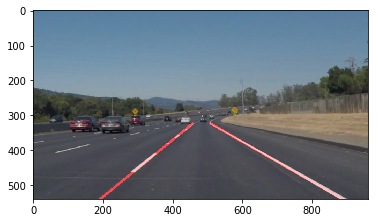

In [5]:
print(images[0])
process_images('test_images/' + images[0])

solidWhiteRight.jpg


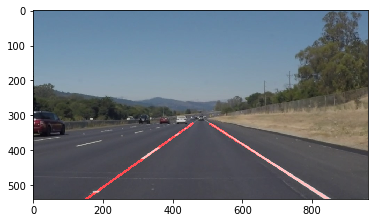

In [6]:
print(images[1])
process_images('test_images/' + images[1])

solidYellowCurve.jpg


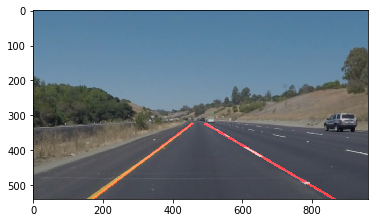

In [7]:
print(images[2])
process_images('test_images/' + images[2])

solidYellowCurve2.jpg


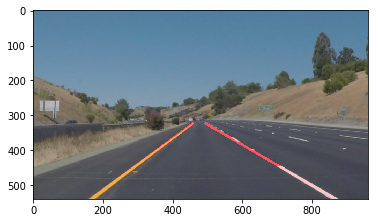

In [8]:
print(images[3])
process_images('test_images/' + images[3])

solidYellowLeft.jpg


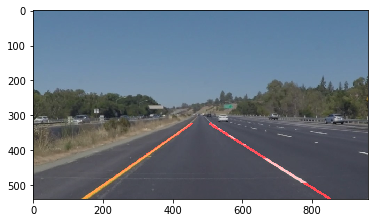

In [9]:
print(images[4])
process_images('test_images/' + images[4])

whiteCarLaneSwitch.jpg


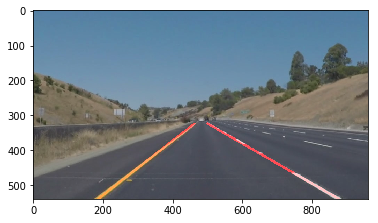

In [10]:
print(images[5])
process_images('test_images/' + images[5])

# Test on videos and Challenge

In [11]:
# pipeline
# almost same thing with process_images, except use cv2.bitwise_or() instead of gray_scale()
# gray_scale() will mess lines when turnning
def process_videos(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(img, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(img, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    blur_gauss = gaussian_blur(gray, 3)
    edges = canny(blur_gauss, 50, 150)
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), ((image.shape[1]*1/2)-20, image.shape[0]*5/8),
                          ((image.shape[1]*1/2)+20, image.shape[0]*5/8), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines(masked_edges, 2, np.pi/180, 30, 100, 160)
    combo = weighted_img(lines, image, 0.9, 0.9)
    return combo

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
white_output = 'white.mp4'  # define output video name
clip1 = VideoFileClip("solidWhiteRight.mp4") # load video and clip as image set
white_clip = clip1.fl_image(process_videos) # process video
%time white_clip.write_videofile(white_output, audio=False) # display the progress bar

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:03<00:00, 58.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.29 s


In [14]:
print('Video: White Output')
HTML("""
<video width="480" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))
# open video file by html 

Video: White Output


In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_videos)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:15<00:00, 38.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 16 s


In [16]:
print('Video: Yellow Output')
HTML("""
<video width="480" height="360" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Video: Yellow Output


In [17]:
challenge_output = 'extra.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_videos)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:12<00:00, 19.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 14.4 s


In [18]:
HTML("""
<video width="480" height="360" controls>
  <source src="{0}">
</video>
""".format(challenge_output))